# Experiment: Prequential Pipeline - Concept Drift Detection

In this experiment we use float to compare the effect of different active concept drift detection techniques. We use a prequential evaluation strategy.

In [1]:
# Optional: Rebase the file path.
# Note that you may also provide explicit file paths and avoid this step.
import os
os.chdir(os.getcwd()[:-18])

In [2]:
# Import modules
import copy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import zero_one_loss
from skmultiflow.drift_detection import ADWIN
from skmultiflow.trees import HoeffdingTreeClassifier
from river.linear_model import Perceptron, LogisticRegression

# Import float modules
from float.data import DataLoader
from float.change_detection import ERICS
from float.change_detection.evaluation import ChangeDetectionEvaluator
from float.change_detection.evaluation.measures import missed_detection_rate, false_discovery_rate, detection_delay
from float.change_detection.skmultiflow import SkmultiflowChangeDetector
from float.pipeline import PrequentialPipeline
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.river import RiverClassifier
import float.visualization as fvis

### Setup *float* modules

#### Create a DataLoader object
We load the TüEyeQ data set, which contains natural concept drift:
https://www.nature.com/articles/s41597-021-00938-3

The sudden drifts in TüEyeQ correspond to three switches between task blocks. Additionally, we may consider each task block as an incremental drift, as the tasks have increasing difficulty. For illustration, we specify a known incremental drift in the second task block (providing a start and end point).

In [3]:
data_loader = DataLoader(path='float/data/datasets/iq.csv',  # This path might have to be adjusted!
                         target_col=-1)

known_drifts = [4707, (9396, 12500), 13570]

#### Create Predictor objects
Specifically, we want to compare models from skmultiflow and river. We use the default parameters of the packages, however, in general you can provide any configuration you like. We specify that the classifiers shall be reset after a concept drift was detected

In [4]:
predictors = [SkmultiflowClassifier(model=HoeffdingTreeClassifier(), 
                                    classes=data_loader.stream.target_values,
                                    reset_after_drift=True),
              RiverClassifier(model=LogisticRegression(), 
                              feature_names=data_loader.stream.feature_names,
                              reset_after_drift=True)]

#### Create a PredictorEvaluator object for the Predictor
The evaluator will compute and store the performance measures w.r.t a predictor object when running the pipeline. Float automatically clones the provided evaluator for each specified predictor object.

In [5]:
pred_evaluator = PredictionEvaluator(measure_funcs=[zero_one_loss])

#### Create ChangeDetector objects
We may use drift detectors from scikit-multiflow, Tornado or pre-build float models like ERICS. For illustration, we compare the ADWIN implementation of scikit-multiflow and the ERICS change detector. Note that we specify that ADWIN shall be reset after a drift was detected, which is not needed by ERICS.

In [6]:
change_detectors = [SkmultiflowChangeDetector(ADWIN(), reset_after_drift=True),
                    ERICS(n_param=data_loader.stream.n_features)]

#### Create a ChangeDetectionEvaluator object for the ChangeDetectors
Aside from monitoring their effect on the overall predictive performance of the classifier, change detectors can be evaluated w.r.t specific measures like missed_detection_rate, false_discovery_rate or detection_delay (these are only some of the measures implemented in float). 

Similar to the PredictionEvaluator, the ChangeDetectionEvaluator will compute and store the performance measures w.r.t a change detector object when running the pipeline. Float automatically clones the provided evaluator for each specified change detector object.

Note that we require ground truth information about known concept drifts if we want to evaluate change detectors w.r.t these measures.

We specify an initial tolerance of 100 observations. In this time period, we do not consider detected drift alerts to give the predictor time for the initial training.

Note that the number of True Positives (which is relevant for some of the measures) depends on the delay after a known drift that we are willing to accept. For example, if we tolerate a delay of 25 observations after a known drift at t=100, then we would count all drift alerts between t=100 and t=125 as True Positives. Via **n_delay**, we can tell the evaluator to compute each measure for 1 or multiple tolerated delays.

Finally, we also need to tell the ChangeDetectionEvaluator which batch size we use in the evaluation, along with the total number of observations.

In [7]:
cd_evaluator = ChangeDetectionEvaluator(measure_funcs=[missed_detection_rate, false_discovery_rate, detection_delay],
                                        known_drifts=known_drifts,
                                        batch_size=10,
                                        n_total=data_loader.stream.n_samples,
                                        n_init_tolerance=100,
                                        n_delay=list(range(100, 200)))

#### Create and run a PrequentialPipeline
We use a batch-incremental scheme, processing the data in batches of size 10. Moreover, we pretrain the classifiers on 200 observations and set a random state for reproducibility.

We run the pipeline twice, using the two different change detectors ADWIN and ERICS in turn.

In [8]:
pipelines = []

for detector in change_detectors:
    pipeline = PrequentialPipeline(data_loader=data_loader,  # The data loader will be automatically reset after finishing the pipeline.
                                   change_detector=detector,
                                   # We clone the evaluator, predictors and prediction_evaluator since we want separate objects for each run.
                                   # This is more concise than specifying separate objects for both pipeline runs.
                                   change_detection_evaluator=copy.deepcopy(cd_evaluator),
                                   predictor=copy.deepcopy(predictors),
                                   prediction_evaluator=copy.deepcopy(pred_evaluator),
                                   batch_size=10,
                                   n_pretrain=200,
                                   n_max=data_loader.stream.n_samples,  # We use all observations
                                   random_state=0)

    pipeline.run()
    pipelines.append(pipeline)

Pretrain the predictor with 200 observation(s).
[                    ] 4%, No. of detected drifts: 0, Last detected drift at t=0 (i.e., at 0% progress).

/Users/johannes/Documents/float/float/pipeline/utils_pipeline.py:110: UserWarning: Known drift positions have been automatically corrected for the number of observations used in pre-training, i.e. known_drift_position -= n_pretrain
  warnings.warn('Known drift positions have been automatically corrected for the number of '


[====================] 100%, No. of detected drifts: 10, Last detected drift at t=1535 (i.e., at 98% progress).
################################## SUMMARY ##################################
Evaluation has finished after 8.490490198135376s
Data Set: float/data/datasets/iq.csv
The PrequentialPipeline has processed 15762 instances, using batches of size 10.
-------------------------------------------------------------------------
*** Prediction ***
Model: SkmultiflowClassifier.HoeffdingTreeClassifier
| Performance Measure   |       Value |
|-----------------------|-------------|
| Avg. Test Comp. Time  | 0.000272907 |
| Avg. Train Comp. Time | 0.0031224   |
| Avg. zero_one_loss    | 0.177763    |
Model: RiverClassifier.LogisticRegression
| Performance Measure   |       Value |
|-----------------------|-------------|
| Avg. Test Comp. Time  | 0.000456805 |
| Avg. Train Comp. Time | 0.000200002 |
| Avg. zero_one_loss    | 0.173756    |
-------------------------------------------------------

/Users/johannes/Documents/float/float/pipeline/utils_pipeline.py:110: UserWarning: Known drift positions have been automatically corrected for the number of observations used in pre-training, i.e. known_drift_position -= n_pretrain
  warnings.warn('Known drift positions have been automatically corrected for the number of '


[====================] 100%, No. of detected drifts: 101, Last detected drift at t=1452 (i.e., at 93% progress).
################################## SUMMARY ##################################
Evaluation has finished after 10.891715049743652s
Data Set: float/data/datasets/iq.csv
The PrequentialPipeline has processed 15762 instances, using batches of size 10.
-------------------------------------------------------------------------
*** Prediction ***
Model: SkmultiflowClassifier.HoeffdingTreeClassifier
| Performance Measure   |       Value |
|-----------------------|-------------|
| Avg. Test Comp. Time  | 0.000460089 |
| Avg. Train Comp. Time | 0.00290834  |
| Avg. zero_one_loss    | 0.197047    |
Model: RiverClassifier.LogisticRegression
| Performance Measure   |       Value |
|-----------------------|-------------|
| Avg. Test Comp. Time  | 0.000449276 |
| Avg. Train Comp. Time | 0.00020104  |
| Avg. zero_one_loss    | 0.173901    |
-----------------------------------------------------

Note that the PrequentialPipeline issues a warning, i.e., it adjusts the specified known drift positions. This is necessary, as we use 200 observations for pretraining, which shifts the relative position of the first time step in the prequential evaluation. That is, the known drift positions in the prequential evaluation will be 200 observations earlier than specified. If we would not correct the known drift positions, the measures of the ChangeDetectionEvaluator would produce biased results.

The printed summary suggests, that the ADWIN change detector has advantages over ERICS w.r.t the false_discovery_rate and the average loss of the Hoeffding Tree. On the other hand, ERICS outperforms ADWIN regarding the detection_delay. Typically, it depends on the application at hand, which performance measures we deem most relevant. In any case, we may gain additional insight by using the float visualization module.

### Visualizing Results
We begin by illustrating the loss measures of each classifier when combined with the two change detectors.

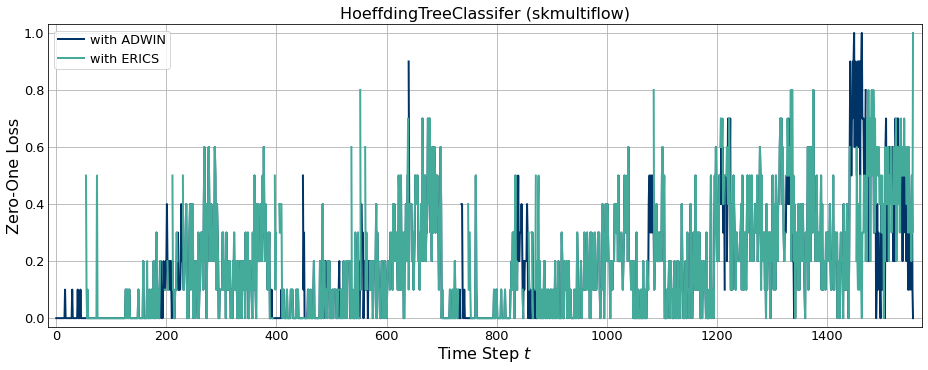

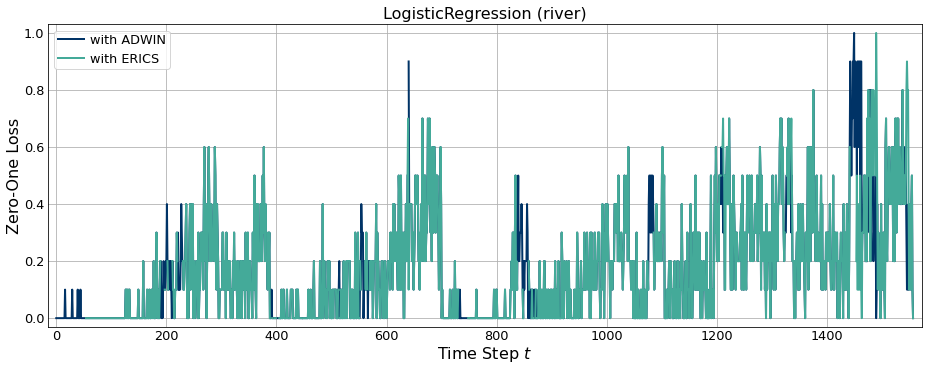

In [9]:
for i, pred_name in enumerate(['HoeffdingTreeClassifer (skmultiflow)', 'LogisticRegression (river)']):
    # Extract the loss measures of the i'th predictor from the two prequential runs.
    measures = [pipelines[0].prediction_evaluators[i].result['zero_one_loss']['measures']]
    measures.append(pipelines[1].prediction_evaluators[i].result['zero_one_loss']['measures'])
    
    ax = fvis.plot(measures=measures,
                   legend_labels=['with ADWIN', 'with ERICS'],
                   fig_size=(13, 5),
                   y_label='Zero-One Loss')

    ax.set_title(pred_name, fontsize=16)
    plt.show()

Based on these line plots, we find that the predictors behave similarly for both change detection models. However, it is still difficult to decide which drift detector is truly better or more reliable. To this end, we may investigate a different plot type.

Aside from standardized plot types like line, bar or scatter, float provides dedicated plot types for change detection and online feature selection. In the following, we demonstrate the **concept_drift_detection_scatter** plot.

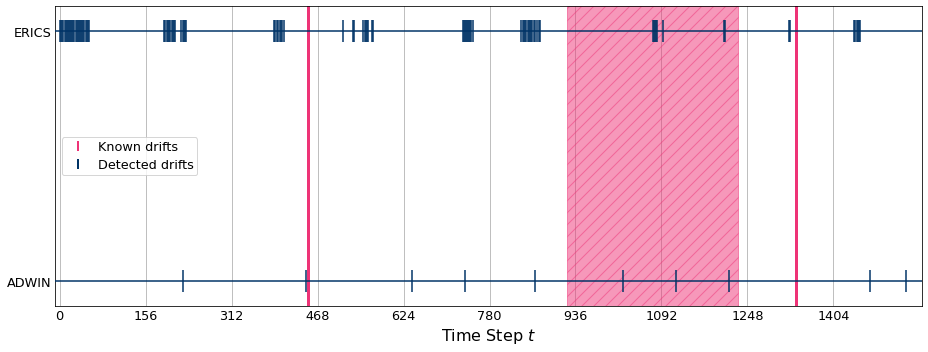

In [10]:
ax = fvis.concept_drift_detection_scatter(detected_drifts=[pipeline.change_detector.drifts for pipeline in pipelines],
                                          model_names=['ADWIN','ERICS'],
                                          fig_size=(13, 5),
                                          n_samples=data_loader.stream.n_samples,
                                          known_drifts=known_drifts,
                                          batch_size=10,
                                          n_pretrain=200)

This plot type enables us to illustrate the detected drifts over time. Known drift positions are highlighted in pink. The incremental drift is depicted by a shaded area, whereas the sudden drifts correspond to vertical lines. With this plot, we can compare different drift detection models in a very concise way. However, in general the plot should always be combined with the dedicated measures that we computed above.

Based on the above plot, we observe that both change detection models identify concept drift at frequent intervals. However, neither model seems to be able to accurately detect the known concept drifts. Note that TüEyeQ is a very small data set with high variability. Consequently, change detection is much more challenging than on larger and less noisy data streams. Still, we might want to evaluate different change detectors next...